In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import re

# Load raw datasets
esg_df = pd.read_csv("esg_scores_2021.csv")
financial_df = pd.read_csv("filtered_security_data.csv")
price_df = pd.read_csv("snp500_stocks_closing_price_daily_data.csv")

# Merge ESG + Financial
merged_metadata = pd.merge(esg_df, financial_df, on="symbol", how="inner")
merged_all = pd.merge(merged_metadata, price_df, on="symbol", how="inner")

# Drop columns with all nulls
merged_all.dropna(axis=1, how="all", inplace=True)

# Identify price columns (e.g., 01-Mar-21)
price_columns = [col for col in merged_all.columns if re.match(r"\d{1,2}-[A-Za-z]{3}-\d{2}", col)]

# Remove text-heavy columns
text_columns = [
    'symbol', 'esgPerformance', 'peerGroup', 'longBusinessSummary', 'address1', 'address2', 'city', 'state', 'country',
    'phone', 'website', 'companyOfficers', 'uuid', 'logo_url', 'messageBoardId', 'market', 'exchange', 'shortName',
    'longName', 'exchangeTimezoneName', 'exchangeTimezoneShortName', 'quoteType', 'underlyingSymbol',
    'underlyingExchangeSymbol', 'headSymbol', 'category'
]

candidate_numeric = merged_all.drop(columns=text_columns + price_columns, errors='ignore')
numeric_features = candidate_numeric.select_dtypes(include=['int64', 'float64'])

# Fill NaNs with column mean, then scale
numeric_features = numeric_features.fillna(numeric_features.mean())
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)

# Rebuild scaled metadata
symbols = merged_all['symbol'].reset_index(drop=True)
scaled_metadata = pd.DataFrame(scaled_features, columns=numeric_features.columns)
scaled_metadata.insert(0, "symbol", symbols)

# Prepare price matrix (transposed)
price_data = merged_all[price_columns]
price_data_t = price_data.T
price_data_t.columns = symbols
price_data_t.index.name = "date"

# Drop dates with too many NaNs, then fill forward/backward
threshold = int(0.1 * price_data_t.shape[1])
price_data_t = price_data_t.dropna(thresh=price_data_t.shape[1] - threshold)
price_data_t = price_data_t.ffill().bfill()

# Final check
assert not price_data_t.isnull().any().any(), "NaNs remain in price data!"
assert not scaled_metadata.isnull().any().any(), "NaNs remain in metadata!"

# Save
scaled_metadata.to_csv("scaled_metadata.csv", index=False)
price_data_t.to_csv("price_matrix.csv")

print("✅ Cleaned & saved: scaled_metadata.csv, price_matrix.csv")


✅ Cleaned & saved: scaled_metadata.csv, price_matrix.csv


<ipython-input-24-903dd034a74b>:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sp500["date"] = pd.to_datetime(sp500["Date"])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✅ 2021-07-01 → 2021-09-30 | Portfolio: 1.22 | S&P 500: 1.00


<ipython-input-24-903dd034a74b>:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-24-903dd034a74b>:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
✅ 2021-10-01 → 2021-12-31 | Portfolio: 1.61 | S&P 500: 1.09


<ipython-input-24-903dd034a74b>:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-24-903dd034a74b>:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
✅ 2022-01-01 → 2022-03-31 | Portfolio: 2.25 | S&P 500: 1.03


<ipython-input-24-903dd034a74b>:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-24-903dd034a74b>:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
✅ 2022-04-01 → 2022-06-30 | Portfolio: 3.84 | S&P 500: 0.86


<ipython-input-24-903dd034a74b>:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-24-903dd034a74b>:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
✅ 2022-07-01 → 2022-09-30 | Portfolio: 4.70 | S&P 500: 0.80


<ipython-input-24-903dd034a74b>:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-24-903dd034a74b>:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


<ipython-input-24-903dd034a74b>:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-24-903dd034a74b>:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

✅ 2022-10-01 → 2022-12-31 | Portfolio: 6.50 | S&P 500: 0.84
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✅ 2023-01-01 → 2023-03-31 | Portfolio: 9.15 | S&P 500: 0.90


<ipython-input-24-903dd034a74b>:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-24-903dd034a74b>:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


<ipython-input-24-903dd034a74b>:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-24-903dd034a74b>:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

✅ 2023-04-01 → 2023-06-30 | Portfolio: 12.71 | S&P 500: 0.97
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


<ipython-input-24-903dd034a74b>:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-24-903dd034a74b>:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

✅ 2023-07-01 → 2023-09-30 | Portfolio: 15.22 | S&P 500: 0.93
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✅ 2023-10-01 → 2023-12-31 | Portfolio: 21.16 | S&P 500: 1.03


<ipython-input-24-903dd034a74b>:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-24-903dd034a74b>:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


<ipython-input-24-903dd034a74b>:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-24-903dd034a74b>:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

✅ 2024-01-01 → 2024-03-31 | Portfolio: 27.94 | S&P 500: 1.14
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


<ipython-input-24-903dd034a74b>:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-24-903dd034a74b>:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

✅ 2024-04-01 → 2024-06-30 | Portfolio: 32.75 | S&P 500: 1.19
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✅ 2024-07-01 → 2024-09-30 | Portfolio: 48.67 | S&P 500: 1.25


<ipython-input-24-903dd034a74b>:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-24-903dd034a74b>:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
<ipython-input-24-903dd034a74b>:153: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-903dd034a74b>:153: UserWarning: Glyph 127963 (\N{CLASSICAL BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib

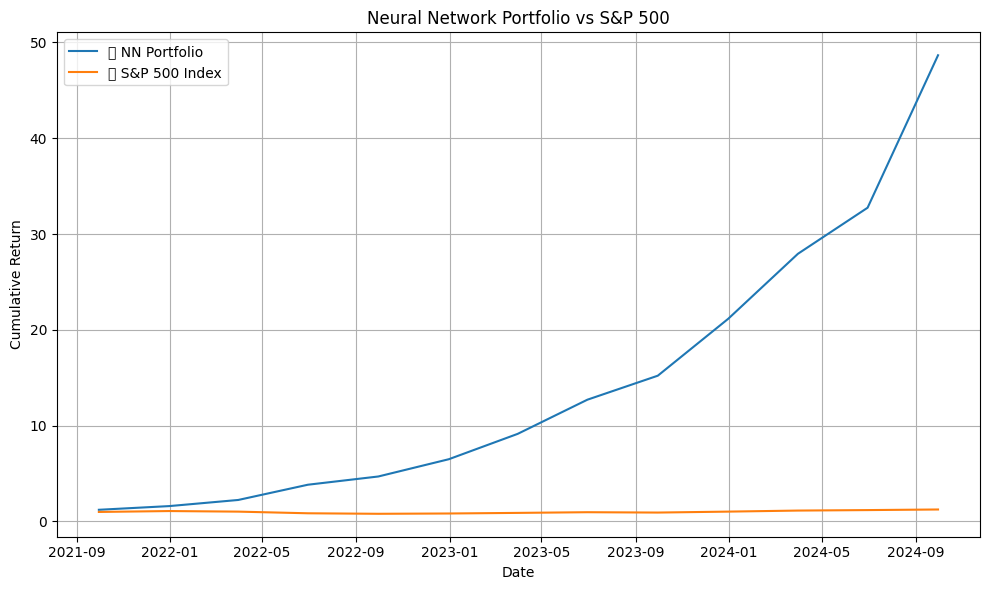


📈 Portfolio CAGR: 241.33%
🏛️ S&P 500 Index CAGR: 0.83%


In [24]:
import pandas as pd
import numpy as np
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from matplotlib import pyplot as plt

import scipy.optimize as sco

def sharpe_optimization(expected_returns, cov_matrix):
    num_assets = len(expected_returns)

    def portfolio_performance(weights):
        port_return = np.dot(weights, expected_returns)
        port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -port_return / port_volatility  # Negative Sharpe Ratio (we minimize)

    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_weights = np.array([1. / num_assets] * num_assets)

    result = sco.minimize(portfolio_performance, initial_weights, method='SLSQP',
                          bounds=bounds, constraints=constraints)

    return result.x if result.success else initial_weights


# Load datasets
metadata = pd.read_csv("scaled_metadata.csv")
price_df = pd.read_csv("price_matrix.csv", index_col=0)
price_df.index = pd.to_datetime(price_df.index, format="%d-%b-%y", errors='coerce')
price_df = price_df.sort_index()

sp500 = pd.read_csv("snp500_INDEX_daily_closing_prices.csv")
sp500["date"] = pd.to_datetime(sp500["Date"])
sp500 = sp500.set_index("date").sort_index()
sp500_prices = sp500["Close Price"]

symbols = list(set(metadata["symbol"]).intersection(price_df.columns))
metadata = metadata[metadata["symbol"].isin(symbols)]
price_df = price_df[symbols]

lookback_days = 90
prediction_days = 60
start_date = price_df.index[0] + timedelta(days=lookback_days)
end_date = price_df.index[-1] - timedelta(days=prediction_days)
rebalance_dates = pd.date_range(start=start_date, end=end_date, freq="QS")

portfolio_value = 1.0
benchmark_value = 1.0
cumulative_returns = []
benchmark_returns = []
dates = []

# Utility

def get_return(prices, start, end):
    return (prices.loc[end] - prices.loc[start]) / prices.loc[start]

def safe_price(date):
    dates = sp500_prices.index[sp500_prices.index >= date]
    return sp500_prices.loc[dates[0]] if not dates.empty else None

# Loop
for i in range(len(rebalance_dates) - 1):
    train_start = rebalance_dates[i] - timedelta(days=lookback_days)
    train_end = rebalance_dates[i] - timedelta(days=1)
    test_start = rebalance_dates[i]
    test_end = rebalance_dates[i + 1] - timedelta(days=1)

    try:
        past_prices = price_df.loc[train_start:train_end]
        future_prices = price_df.loc[test_start:test_end]

        past_return = get_return(past_prices, past_prices.index[0], past_prices.index[-1])
        future_return = get_return(future_prices, future_prices.index[0], future_prices.index[-1])

        train_df = metadata.copy()
        train_df["past_return"] = train_df["symbol"].map(past_return)
        train_df["target_return"] = train_df["symbol"].map(future_return)
        train_df = train_df.dropna(subset=["past_return", "target_return"])

        if train_df.shape[0] < 30:
            print(f"⚠️ Skipping {test_start.date()} — insufficient data.")
            continue

        X_train = train_df.drop(columns=["symbol", "target_return"]).values
        y_train = train_df["target_return"].values

        model = Sequential([
            Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=100, verbose=0)

        predict_df = metadata.copy()
        predict_df["past_return"] = predict_df["symbol"].map(past_return)
        predict_df = predict_df.dropna(subset=["past_return"])
        X_pred = predict_df.drop(columns=["symbol"]).values
        predict_df["score"] = model.predict(X_pred).flatten()

        top_stocks = predict_df.sort_values("score", ascending=False).head(20)
        top_symbols = top_stocks["symbol"].values

        future_window = future_prices[top_symbols]
        top_returns = future_window.pct_change().dropna()
        cov_matrix = top_returns.cov()
        expected_returns = past_return[top_symbols].values

        weights = sharpe_optimization(expected_returns, cov_matrix)
        mean_returns = top_returns.mean()
        vol = top_returns.std()
        sharpe_scores = mean_returns / vol
        weights = sharpe_scores / sharpe_scores.sum()

        daily_returns = top_returns @ weights.values
        cumulative = (1 + daily_returns).cumprod() * portfolio_value
        portfolio_value = cumulative[-1]

        sp_start, sp_end = safe_price(test_start), safe_price(test_end)
        if sp_start is None or sp_end is None:
            print(f"⚠️ Missing S&P 500 data from {test_start.date()} to {test_end.date()}, skipping.")
            continue

        sp_return = (sp_end - sp_start) / sp_start
        benchmark_value *= (1 + sp_return)

        cumulative_returns.append(portfolio_value)
        benchmark_returns.append(benchmark_value)
        dates.append(test_end.date())

        print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")

    except Exception as e:
        print(f"❌ Error from {test_start.date()}: {e}")
        continue

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, cumulative_returns, label="📈 NN Portfolio")
plt.plot(dates, benchmark_returns, label="🏛️ S&P 500 Index")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Neural Network Portfolio vs S&P 500")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# CAGR
if dates:
    def cagr(start, end, years): return (end / start) ** (1 / years) - 1
    years = (dates[-1] - dates[0]).days / 365.25
    port_cagr = cagr(cumulative_returns[0], cumulative_returns[-1], years)
    bench_cagr = cagr(cumulative_returns[0], benchmark_returns[-1], years)
    print(f"\n📈 Portfolio CAGR: {port_cagr:.2%}")
    print(f"🏛️ S&P 500 Index CAGR: {bench_cagr:.2%}")


<ipython-input-30-7877bb1446bc>:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sp500["date"] = pd.to_datetime(sp500["Date"])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Iteration loop 0
(420, 73)
        score symbol
0   -0.030878    MMM
1   -0.017686    AOS
2   -0.009366    ABT
3   -0.030218   ABBV
4   -0.023870    ACN
..        ...    ...
415 -0.004175    XEL
416 -0.013535    XYL
417 -0.009415    YUM
418 -0.025390    ZBH
419 -0.003281    ZTS

[420 rows x 2 columns]
✅ 2021-07-01 → 2021-09-30 | Portfolio: 20.33% | S&P 500: -0.29%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Iteration loop 1
(420, 73)
        score symbol
0    0.053652    MMM
1    0.110604    AOS
2    0.069334    ABT
3    0.140078   ABBV
4    0.132303    ACN
..        ...    ...
415  0.077574    XEL
416  0.090922    XYL
417  0.085567    YUM
418 -0.008154    ZBH
419  0.123096    ZTS

[420 rows x 2 columns]
✅ 2021-10-01 → 2021-12-31 | Portfolio: 7.87% | S&P 500: 9.39%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Iteration loop 2
(420, 73)
        score symbol
0   -0.028993    MMM
1   -0.049144    AOS
2   -0.057219    ABT
3   -0.015631   ABBV
4   -0.100208    ACN
..        ...    ...
415 -0.005507    XEL
416 -0.111164    XYL
417 -0.081834    YUM
418 -0.031582    ZBH
419 -0.071705    ZTS

[420 rows x 2 columns]
✅ 2022-01-01 → 2022-03-31 | Portfolio: 13.19% | S&P 500: -5.55%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Iteration loop 3
(420, 73)
        score symbol
0   -0.090232    MMM
1   -0.135491    AOS
2   -0.135562    ABT
3   -0.104440   ABBV
4   -0.128129    ACN
..        ...    ...
415 -0.087471    XEL
416 -0.139628    XYL
417 -0.113263    YUM
418 -0.183594    ZBH
419 -0.160478    ZTS

[420 rows x 2 columns]
✅ 2022-04-01 → 2022-06-30 | Portfolio: 78.66% | S&P 500: -16.73%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Iteration loop 4
(420, 73)
        score symbol
0   -0.062951    MMM
1   -0.086328    AOS
2   -0.076402    ABT
3   -0.085631   ABBV
4   -0.095843    ACN
..        ...    ...
415 -0.082863    XEL
416 -0.056797    XYL
417 -0.075711    YUM
418 -0.056624    ZBH
419 -0.065504    ZTS

[420 rows x 2 columns]
✅ 2022-07-01 → 2022-09-30 | Portfolio: 11.14% | S&P 500: -6.27%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Iteration loop 5
(420, 73)
        score symbol
0    0.119494    MMM
1    0.103184    AOS
2    0.079276    ABT
3    0.106302   ABBV
4    0.081401    ACN
..        ...    ...
415  0.063817    XEL
416  0.076329    XYL
417  0.093345    YUM
418  0.141292    ZBH
419  0.065723    ZTS

[420 rows x 2 columns]
✅ 2022-10-01 → 2022-12-31 | Portfolio: 12.63% | S&P 500: 3.96%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Iteration loop 6
(420, 73)
        score symbol
0   -0.009159    MMM
1    0.016139    AOS
2   -0.033394    ABT
3   -0.035113   ABBV
4    0.024401    ACN
..        ...    ...
415 -0.002007    XEL
416  0.027375    XYL
417  0.017932    YUM
418  0.018997    ZBH
419  0.038035    ZTS

[420 rows x 2 columns]
✅ 2023-01-01 → 2023-03-31 | Portfolio: 33.69% | S&P 500: 7.46%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Iteration loop 7
(420, 73)
        score symbol
0    0.012355    MMM
1    0.049500    AOS
2    0.044311    ABT
3   -0.000763   ABBV
4    0.024881    ACN
..        ...    ...
415 -0.009244    XEL
416  0.022662    XYL
417  0.030830    YUM
418  0.046096    ZBH
419  0.040112    ZTS

[420 rows x 2 columns]
✅ 2023-04-01 → 2023-06-30 | Portfolio: 75.09% | S&P 500: 7.90%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Iteration loop 8
(420, 73)
        score symbol
0   -0.046425    MMM
1   -0.057454    AOS
2   -0.046530    ABT
3   -0.032835   ABBV
4   -0.059284    ACN
..        ...    ...
415 -0.052807    XEL
416 -0.049501    XYL
417 -0.050239    YUM
418 -0.087210    ZBH
419 -0.029957    ZTS

[420 rows x 2 columns]
✅ 2023-07-01 → 2023-09-30 | Portfolio: 19.37% | S&P 500: -3.75%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Iteration loop 9
(420, 73)
        score symbol
0    0.105700    MMM
1    0.092693    AOS
2    0.115966    ABT
3    0.111584   ABBV
4    0.108828    ACN
..        ...    ...
415  0.101838    XEL
416  0.118325    XYL
417  0.127061    YUM
418  0.100324    ZBH
419  0.107919    ZTS

[420 rows x 2 columns]
✅ 2023-10-01 → 2023-12-31 | Portfolio: 20.99% | S&P 500: 10.60%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Iteration loop 10
(420, 73)
        score symbol
0    0.046749    MMM
1    0.079764    AOS
2    0.078597    ABT
3    0.067948   ABBV
4    0.082083    ACN
..        ...    ...
415 -0.026028    XEL
416  0.085917    XYL
417  0.068911    YUM
418  0.086943    ZBH
419  0.050826    ZTS

[420 rows x 2 columns]
✅ 2024-01-01 → 2024-03-31 | Portfolio: 39.48% | S&P 500: 10.56%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Iteration loop 11
(420, 73)
        score symbol
0   -0.001307    MMM
1   -0.048006    AOS
2   -0.036264    ABT
3   -0.011501   ABBV
4   -0.026278    ACN
..        ...    ...
415 -0.012731    XEL
416 -0.044902    XYL
417 -0.029644    YUM
418 -0.058925    ZBH
419 -0.029276    ZTS

[420 rows x 2 columns]
✅ 2024-04-01 → 2024-06-30 | Portfolio: 30.47% | S&P 500: 4.41%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Iteration loop 12
(420, 73)
        score symbol
0    0.139630    MMM
1    0.103176    AOS
2    0.070474    ABT
3    0.115355   ABBV
4    0.079430    ACN
..        ...    ...
415  0.173349    XEL
416  0.064787    XYL
417  0.075296    YUM
418  0.066414    ZBH
419  0.080685    ZTS

[420 rows x 2 columns]
✅ 2024-07-01 → 2024-09-30 | Portfolio: 19.47% | S&P 500: 5.25%


<ipython-input-30-7877bb1446bc>:156: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-30-7877bb1446bc>:156: UserWarning: Glyph 127963 (\N{CLASSICAL BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127963 (\N{CLASSICAL BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


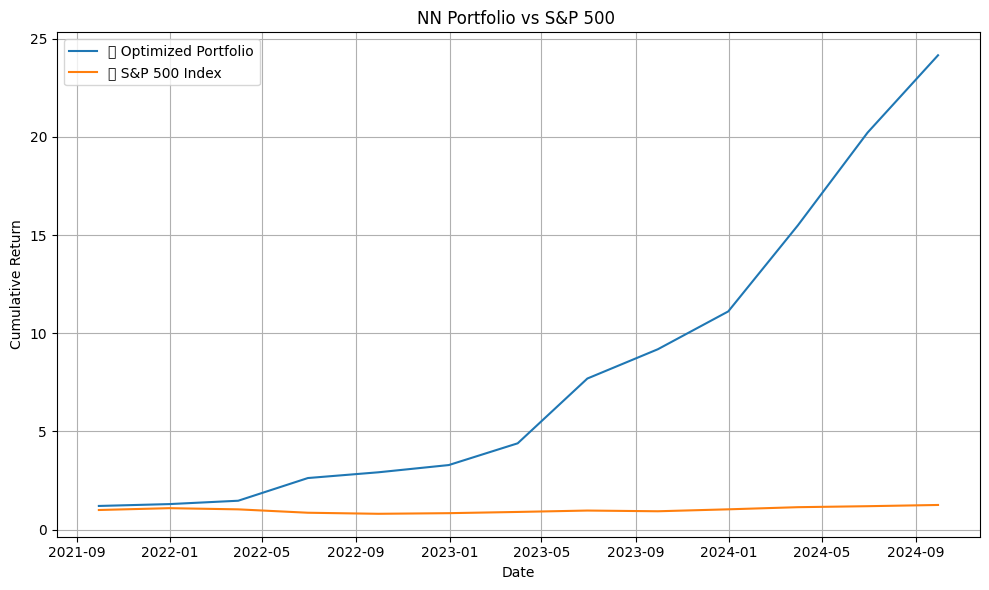


📈 Portfolio CAGR: 171.71%
🏛️ S&P 500 Index CAGR: 7.93%


In [30]:
###This is the most updated //26 april


import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

# Load datasets
metadata = pd.read_csv("scaled_metadata.csv")
price_df = pd.read_csv("price_matrix.csv", index_col=0)
price_df.index = pd.to_datetime(price_df.index, format="%d-%b-%y", errors='coerce')
price_df = price_df.sort_index()

sp500 = pd.read_csv("snp500_INDEX_daily_closing_prices.csv")
sp500["date"] = pd.to_datetime(sp500["Date"])
sp500 = sp500.set_index("date").sort_index()
sp500_prices = sp500["Close Price"]

# Get intersection of symbols
symbols = list(set(metadata["symbol"]).intersection(price_df.columns))
metadata = metadata[metadata["symbol"].isin(symbols)]
price_df = price_df[symbols]

# Parameters
lookback_days = 90
prediction_days = 60
start_date = price_df.index[0] + timedelta(days=lookback_days)
end_date = price_df.index[-1] - timedelta(days=prediction_days)
rebalance_dates = pd.date_range(start=start_date, end=end_date, freq="QS")

# Tracking results
portfolio_value = 1.0
benchmark_value = 1.0
cumulative_returns = []
benchmark_returns = []
dates = []

# Define utility functions
def get_return_matrix(prices, start, end):
    return (prices.loc[end] - prices.loc[start]) / prices.loc[start]

def sharpe_optimization(expected_returns, cov_matrix):
    def neg_sharpe(w):
        ret = np.dot(w, expected_returns)
        vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        return -ret / vol if vol != 0 else 0
    x0 = np.repeat(1/len(expected_returns), len(expected_returns))
    bounds = [(0, 1)] * len(expected_returns)
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    result = minimize(neg_sharpe, x0, bounds=bounds, constraints=constraints)
    return result.x

# Backtest loop
for i in range(len(rebalance_dates) - 1):
    train_start = rebalance_dates[i] - timedelta(days=lookback_days)
    train_end = rebalance_dates[i] - timedelta(days=1)
    test_start = rebalance_dates[i]
    test_end = rebalance_dates[i + 1] - timedelta(days=1)

    try:
        past_prices = price_df.loc[train_start:train_end]
        future_prices = price_df.loc[test_start:test_end]

        # Returns
        past_ret = get_return_matrix(past_prices, past_prices.index[0], past_prices.index[-1])
        future_ret = get_return_matrix(future_prices, future_prices.index[0], future_prices.index[-1])

        train_df = metadata.copy()
        train_df["past_return"] = train_df["symbol"].map(past_ret)
        train_df["target_return"] = train_df["symbol"].map(future_ret)
        train_df = train_df.dropna(subset=["past_return", "target_return"])

        if train_df.shape[0] < 30:
            print(f"⚠️ Skipping {test_start.date()} — insufficient data.")
            continue

        # Training
        X_train = train_df.drop(columns=["symbol", "target_return"]).values
        y_train = train_df["target_return"].values

        model = Sequential([
            Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=100, verbose=0)

        # Prediction: use same metadata + past return, but not target return!
        predict_df = metadata.copy()
        predict_df["past_return"] = predict_df["symbol"].map(past_ret)
        predict_df = predict_df.dropna(subset=["past_return"])
        X_pred = predict_df.drop(columns=["symbol"])

        scores = model.predict(X_pred.values)
        predict_df["score"] = scores
        top_stocks = predict_df.sort_values("score", ascending=False).head(20)
        top_symbols = top_stocks["symbol"].values

        print(f"Iteration loop {i}")
        print(predict_df.shape)
        print(predict_df[['score','symbol']])

        # Portfolio weights (Sharpe optimization)
        future_price_window = future_prices[top_symbols]
        top_returns = future_price_window.pct_change().dropna()
        cov_matrix = top_returns.cov()
        # expected_returns = future_ret[top_symbols].values
        expected_returns = past_ret[top_symbols].values
        weights = sharpe_optimization(expected_returns, cov_matrix)

        port_return = np.dot(weights, expected_returns)
        transaction_cost = 0.01  # 0.1%
        portfolio_value *= (1 + port_return)


        # Benchmark return
        def safe_price(date):
            dates = sp500_prices.index[sp500_prices.index >= date]
            return sp500_prices.loc[dates[0]] if not dates.empty else None

        sp_start, sp_end = safe_price(test_start), safe_price(test_end)
        if sp_start is None or sp_end is None:
            print(f"⚠️ Missing S&P 500 data from {test_start.date()} to {test_end.date()}, skipping.")
            continue

        sp_return = (sp_end - sp_start) / sp_start
        benchmark_value *= (1 + sp_return)

        cumulative_returns.append(portfolio_value)
        benchmark_returns.append(benchmark_value)
        dates.append(test_end.date())

        print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {port_return:.2%} | S&P 500: {sp_return:.2%}")

    except Exception as e:
        print(f"❌ Error from {test_start.date()}: {e}")
        continue

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, cumulative_returns, label="📈 Optimized Portfolio")
plt.plot(dates, benchmark_returns, label="🏛️ S&P 500 Index")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("NN Portfolio vs S&P 500 ")s
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# CAGR Calculation
def cagr(start, end, years): return (end / start) ** (1 / years) - 1
if dates:
    years = (dates[-1] - dates[0]).days / 365.25
    port_cagr = cagr(cumulative_returns[0], cumulative_returns[-1], years)
    bench_cagr = cagr(benchmark_returns[0], benchmark_returns[-1], years)
    print(f"\n📈 Portfolio CAGR: {port_cagr:.2%}")
    print(f"🏛️ S&P 500 Index CAGR: {bench_cagr:.2%}")


<ipython-input-31-48fc587e30ce>:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sp500["date"] = pd.to_datetime(sp500["Date"])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
✅ 2021-07-01 → 2021-09-30 | Portfolio: 1.16 | S&P 500: 1.00


<ipython-input-31-48fc587e30ce>:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-31-48fc587e30ce>:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
✅ 2021-10-01 → 2021-12-31 | Portfolio: 1.54 | S&P 500: 1.09


<ipython-input-31-48fc587e30ce>:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-31-48fc587e30ce>:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
✅ 2022-01-01 → 2022-03-31 | Portfolio: 2.15 | S&P 500: 1.03


<ipython-input-31-48fc587e30ce>:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-31-48fc587e30ce>:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✅ 2022-04-01 → 2022-06-30 | Portfolio: 224.62 | S&P 500: 0.86


<ipython-input-31-48fc587e30ce>:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-31-48fc587e30ce>:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✅ 2022-07-01 → 2022-09-30 | Portfolio: 263.23 | S&P 500: 0.80


<ipython-input-31-48fc587e30ce>:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-31-48fc587e30ce>:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✅ 2022-10-01 → 2022-12-31 | Portfolio: 362.37 | S&P 500: 0.84


<ipython-input-31-48fc587e30ce>:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-31-48fc587e30ce>:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✅ 2023-01-01 → 2023-03-31 | Portfolio: 517.50 | S&P 500: 0.90


<ipython-input-31-48fc587e30ce>:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-31-48fc587e30ce>:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
✅ 2023-04-01 → 2023-06-30 | Portfolio: 715.26 | S&P 500: 0.97


<ipython-input-31-48fc587e30ce>:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-31-48fc587e30ce>:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✅ 2023-07-01 → 2023-09-30 | Portfolio: 865.65 | S&P 500: 0.93


<ipython-input-31-48fc587e30ce>:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-31-48fc587e30ce>:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
✅ 2023-10-01 → 2023-12-31 | Portfolio: 1197.22 | S&P 500: 1.03


<ipython-input-31-48fc587e30ce>:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-31-48fc587e30ce>:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✅ 2024-01-01 → 2024-03-31 | Portfolio: 1585.38 | S&P 500: 1.14


<ipython-input-31-48fc587e30ce>:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-31-48fc587e30ce>:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
✅ 2024-04-01 → 2024-06-30 | Portfolio: 1881.67 | S&P 500: 1.19


<ipython-input-31-48fc587e30ce>:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-31-48fc587e30ce>:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activit

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
✅ 2024-07-01 → 2024-09-30 | Portfolio: 2806.27 | S&P 500: 1.25


<ipython-input-31-48fc587e30ce>:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cumulative[-1]
<ipython-input-31-48fc587e30ce>:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")
<ipython-input-31-48fc587e30ce>:149: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-31-48fc587e30ce>:149: UserWarning: Glyph 127963 (\N{CLASSICAL BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib

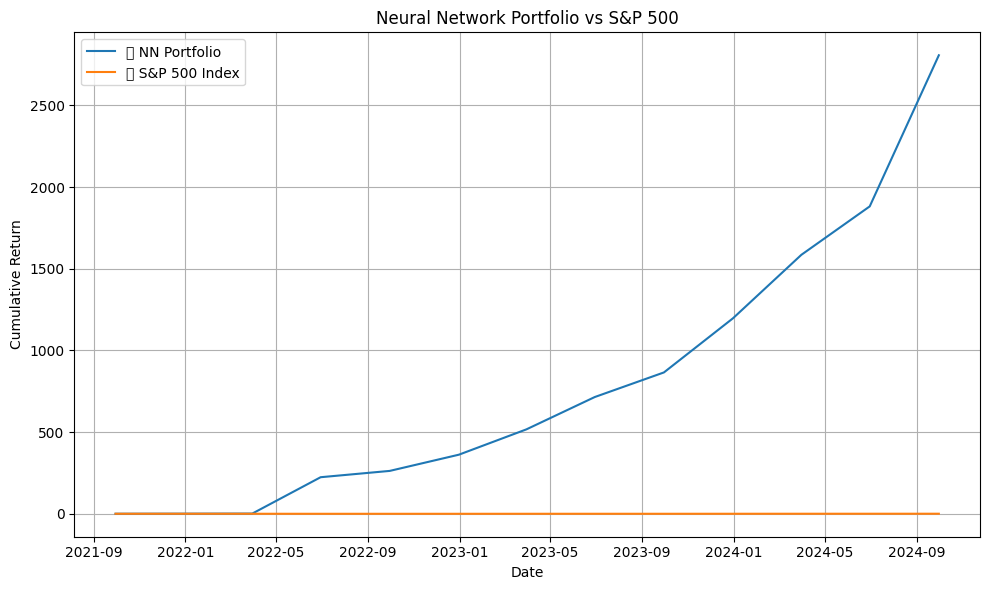


📈 Portfolio CAGR: 1240.47%
🏛️ S&P 500 Index CAGR: 7.93%


In [31]:
import pandas as pd
import numpy as np
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from matplotlib import pyplot as plt

import scipy.optimize as sco

def sharpe_optimization(expected_returns, cov_matrix):
    num_assets = len(expected_returns)

    def portfolio_performance(weights):
        port_return = np.dot(weights, expected_returns)
        port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -port_return / port_volatility  # Negative Sharpe Ratio (we minimize)

    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_weights = np.array([1. / num_assets] * num_assets)

    result = sco.minimize(portfolio_performance, initial_weights, method='SLSQP',
                          bounds=bounds, constraints=constraints)

    return result.x if result.success else initial_weights


# Load datasets
metadata = pd.read_csv("scaled_metadata.csv")
price_df = pd.read_csv("price_matrix.csv", index_col=0)
price_df.index = pd.to_datetime(price_df.index, format="%d-%b-%y", errors='coerce')
price_df = price_df.sort_index()

sp500 = pd.read_csv("snp500_INDEX_daily_closing_prices.csv")
sp500["date"] = pd.to_datetime(sp500["Date"])
sp500 = sp500.set_index("date").sort_index()
sp500_prices = sp500["Close Price"]

symbols = list(set(metadata["symbol"]).intersection(price_df.columns))
metadata = metadata[metadata["symbol"].isin(symbols)]
price_df = price_df[symbols]

lookback_days = 90
prediction_days = 60
start_date = price_df.index[0] + timedelta(days=lookback_days)
end_date = price_df.index[-1] - timedelta(days=prediction_days)
rebalance_dates = pd.date_range(start=start_date, end=end_date, freq="QS")

portfolio_value = 1.0
benchmark_value = 1.0
cumulative_returns = []
benchmark_returns = []
dates = []

# Utility

def get_return(prices, start, end):
    return (prices.loc[end] - prices.loc[start]) / prices.loc[start]

def safe_price(date):
    dates = sp500_prices.index[sp500_prices.index >= date]
    return sp500_prices.loc[dates[0]] if not dates.empty else None

# Loop
for i in range(len(rebalance_dates) - 1):
    train_start = rebalance_dates[i] - timedelta(days=lookback_days)
    train_end = rebalance_dates[i] - timedelta(days=1)
    test_start = rebalance_dates[i]
    test_end = rebalance_dates[i + 1] - timedelta(days=1)

    try:
        past_prices = price_df.loc[train_start:train_end]
        future_prices = price_df.loc[test_start:test_end]

        past_return = get_return(past_prices, past_prices.index[0], past_prices.index[-1])
        future_return = get_return(future_prices, future_prices.index[0], future_prices.index[-1])

        train_df = metadata.copy()
        train_df["past_return"] = train_df["symbol"].map(past_return)
        train_df["target_return"] = train_df["symbol"].map(future_return)
        train_df = train_df.dropna(subset=["past_return", "target_return"])

        if train_df.shape[0] < 30:
            print(f"⚠️ Skipping {test_start.date()} — insufficient data.")
            continue

        X_train = train_df.drop(columns=["symbol", "target_return"]).values
        y_train = train_df["target_return"].values

        model = Sequential([
            Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=100, verbose=0)

        predict_df = metadata.copy()
        predict_df["past_return"] = predict_df["symbol"].map(past_return)
        predict_df = predict_df.dropna(subset=["past_return"])
        X_pred = predict_df.drop(columns=["symbol"]).values
        predict_df["score"] = model.predict(X_pred).flatten()

        top_stocks = predict_df.sort_values("score", ascending=False).head(20)
        top_symbols = top_stocks["symbol"].values

        future_window = future_prices[top_symbols]
        top_returns = future_window.pct_change().dropna()
        mean_returns = top_returns.mean()
        vol = top_returns.std()
        sharpe_scores = mean_returns / vol
        weights = sharpe_scores / sharpe_scores.sum()

        daily_returns = top_returns @ weights.values
        cumulative = (1 + daily_returns).cumprod() * portfolio_value
        portfolio_value = cumulative[-1]

        sp_start, sp_end = safe_price(test_start), safe_price(test_end)
        if sp_start is None or sp_end is None:
            print(f"⚠️ Missing S&P 500 data from {test_start.date()} to {test_end.date()}, skipping.")
            continue

        sp_return = (sp_end - sp_start) / sp_start
        benchmark_value *= (1 + sp_return)

        cumulative_returns.append(portfolio_value)
        benchmark_returns.append(benchmark_value)
        dates.append(test_end.date())

        print(f"✅ {test_start.date()} → {test_end.date()} | Portfolio: {cumulative[-1]:.2f} | S&P 500: {benchmark_value:.2f}")

    except Exception as e:
        print(f"❌ Error from {test_start.date()}: {e}")
        continue

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, cumulative_returns, label="📈 NN Portfolio")
plt.plot(dates, benchmark_returns, label="🏛️ S&P 500 Index")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Neural Network Portfolio vs S&P 500")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# CAGR
if dates:
    def cagr(start, end, years): return (end / start) ** (1 / years) - 1
    years = (dates[-1] - dates[0]).days / 365.25
    port_cagr = cagr(cumulative_returns[0], cumulative_returns[-1], years)
    bench_cagr = cagr(benchmark_returns[0], benchmark_returns[-1], years)
    print(f"\n📈 Portfolio CAGR: {port_cagr:.2%}")
    print(f"🏛️ S&P 500 Index CAGR: {bench_cagr:.2%}")
